 Lab Deep Learning / Multi-Layer Perceptron for regression / in pytorch

**Author: geoffroy.peeters@telecom-paris.fr**

For any remark or suggestion, please feel free to contact me.

Last edits:
- 2020/03/24 peeters (change dimensions order)
- 2020/04/27 peeters (added comments on W1, W2 initialization, added comments on A and B)
- 2021/05/05 peeters (add some documentation related to ```W1 -= ...```)

Read the "introduction to pytorch" 
- slides: https://perso.telecom-paristech.fr/gpeeters/doc/pytorch/
- video: https://perso.telecom-paristech.fr/gpeeters/video/pytorch.mp4


## Objective:

The objective of this lab is to demonstrate the use of Neural Networks to perform non-linear regression.
We will use a simple NN with 1 hidden layer. The hidden layer has $n_h$ (you will test various values of $n_h$) hidden units and either a ```sigmoid```, ```relu``` or ```tanh``` activation.
Since we perform a regression task the output $\hat{y} \in \mathbb{R}$ and  there is no output activation (linear).

You will perform 1000 iterations (epochs) of SGD to find the parameters.

You will then apply the network to the two datasets A and B.

Note: for this lab, we do not separate the dataset into a train, validation and test part. We simply check the ```capacity``` of the network to model the training data.

**Question**: according to the obtained loss, discuss the choice of ```sigmoid```, ```relu``` or ```tanh```.



### Data normalization

You should normalize the data to zero mean and unit standard deviation

### Model

There are various ways to write a NN model in pytorch. 

In this lab, you will write three different implementations:
- **Model A**: manually defining the parameters (W1,b1,w2,b2), writting the forward equations, writting the loss equation, calling the .backward() and manually updating the weights using W1.grad. You will write the loop to perform 1000 epochs.
- **Model B**: using the Sequential class of pytorch
- **Model C**: a custom torch.nn.Module class for this.

For Model B and C, you will use the ready made loss and optimization from the nn and optim packages. You can use the same code to optimize the parameters of Model B and C.

### Loss

Since we are dealing with a regression problem, we will use a Mean Square Error loss (use ```torch.nn.MSELoss``` for Model B and C).

### Parameters update/ Optimization

For updating the parameters, we will use as optimizer a simple SGD algorithm (use ```torch.optim.SGD``` for Model B and C) with a learning rate of 0.05.

Don't forget that an optimizer is applied to a set of parameters (```my_model.parameters()``` gives the parameters of the network for Model B and C).
Once the gradients have been computed (after the backpropagation has been performed), you can perform one step of optimization (using ```optimizer.step()``` for Model B and C).

### Backward propagation

Backpropagation is automatically performed in pytorch using the ```autograd``` package. 
First, reset the gradients of all parameters (using ```optimizer.zero_grad()``` for Model B and C), then perform the backpropagation ```loss.backward()```. 

### Regularization

- How can you add a Ridge (L2) regularization ? this can be done easely within the definition of the ```optimizer```.
- How can you add a Lasso (L1) regularization ? this has to be done manually at each iteration, by adding something to the loss before backpropagation.

**Question**: discuss the use of the Ridge and Lasso regularization for each dataset.

## Your task:

You need to add the missing parts in the code (parts between ```# --- START CODE HERE``` and ```# --- END CODE HERE```)

## Load the python packages

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

## Datasets

We will use two different datasets. For both $x$ has dimensions $(m,n_{in}=1)$ and $y$ has dimensions $(m,n_{out}=1)$ where $m$ is the number of examples.

### Dataset A

size of x_data: torch.Size([100, 1])
size of y_data: torch.Size([100, 1])


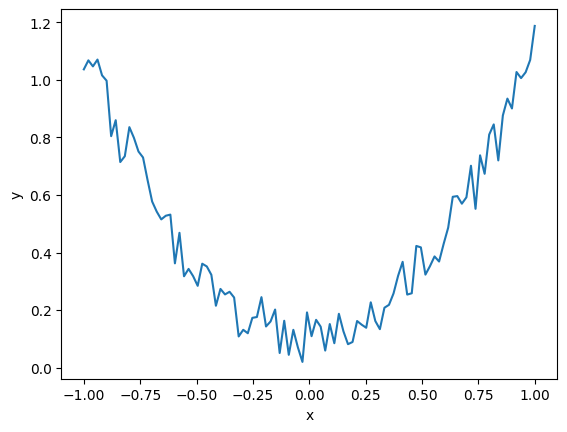

In [26]:
m = 100

x_data = torch.linspace(-1, 1, m)
noise_data = 0.2*torch.rand(m)
y_data = x_data.pow(2) + noise_data

# --- change vectos to matrix
x_data = torch.unsqueeze(x_data, dim=1)
y_data = torch.unsqueeze(y_data, dim=1)

# ----------------
plt.plot(x_data.numpy(), y_data.numpy());
plt.xlabel('x'), plt.ylabel('y');

print('size of x_data:', x_data.size())
print('size of y_data:', y_data.size())

## Dataset B

size of x_data: torch.Size([3000, 1])
size of y_data: torch.Size([3000, 1])


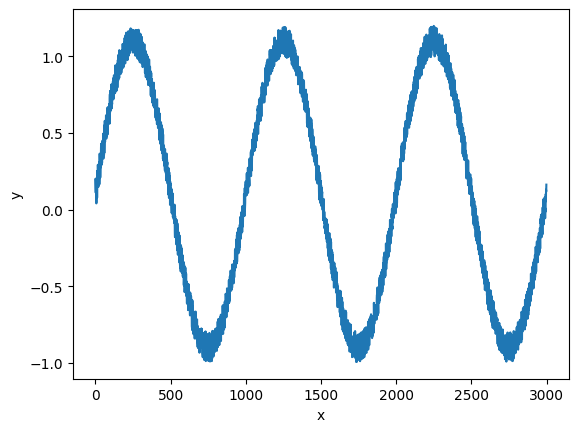

In [27]:
m = 3000

x_data = torch.arange(0, m, dtype=torch.float32)
noise_data = 0.2*torch.rand(m)
y_data = torch.sin(2*np.pi*x_data*0.001) + noise_data

# --- change vectos to matrix
x_data = torch.unsqueeze(x_data, dim=1)
y_data = torch.unsqueeze(y_data, dim=1)

# ----------------
plt.plot(x_data.numpy(),y_data.numpy())
plt.xlabel('x'), plt.ylabel('y');

print('size of x_data:', x_data.size())
print('size of y_data:', y_data.size())

# **On the next code cell, you have to change the value of Choose_your_dataset to 'A' or 'B' given the data set you want to apply the neural network on**

In [28]:
Choose_your_dataset ='B'
match(Choose_your_dataset):
  case 'A' : 
    m = 100
    x_data = torch.linspace(-1, 1, m)
    noise_data = 0.2*torch.rand(m)
    y_data = x_data.pow(2) + noise_data
    x_data = torch.unsqueeze(x_data, dim=1)
    y_data = torch.unsqueeze(y_data, dim=1)
  case 'B' : 
    m = 3000
    x_data = torch.arange(0, m, dtype=torch.float32)
    noise_data = 0.2*torch.rand(m)
    y_data = torch.sin(2*np.pi*x_data*0.001) + noise_data
    x_data = torch.unsqueeze(x_data, dim=1)
    y_data = torch.unsqueeze(y_data, dim=1)


## Data standardization

We standardize the input data (substract mean and divide by standard-deviation)

In [29]:
# --- START CODE HERE
x_data = (x_data - torch.mean(x_data))/torch.std(x_data)
y_data = (y_data - torch.mean(y_data))/torch.std(y_data)
# --- END CODE HERE

## Definition of the hyper-parameters

In [30]:
n_in = 1
n_h = 10
n_out = 1

nbEpoch = 20000
alpha = 0.05

## Model 1 (writting the network equations)

For model 1, you will define the variables and write the equations of the network yourself (as you would do in numpy).
However you will use ```torch tensors``` instead of ```numpy array```. 

***Why ?*** because torch tensors will allows you to automatically get the gradient. You will use ```loss.backward()``` to launch the backpropagation from the ```loss``` variable. 
Then, for all torch tensors you have created and for which you have declared ```requires_grad=True```, you will get the gradient of ```loss```with respect to this variable in the field ```.grad```. 

***Example*** ```W1 = torch.tensors(..., requires_grad=True)``` ... ```loss.backward()``` will have the gradient $\frac{d Loss}{d W1}$in ```W1.grad```.

### Initialize the variables

**Note**: In order to avoid neuron saturation and that all the neurons learn the same thing, the matrix should be initialized to a small random value (see https://pytorch.org/docs/stable/nn.html#linear for details). Because of this, W1 and W2 should be first define as small random; **then** set to ```requires_grad=True```.

In [31]:
# --- START CODE HERE
W1 = torch.randn(n_in, n_h, requires_grad = True)
b1 = torch.randn(n_h, requires_grad = True)
W2 = torch.randn(n_h, n_out, requires_grad = True)
b2 = torch.randn(n_out, requires_grad = True)
# --- END CODE HERE

### Define the model

We will denote by ```H``` the pre-activation (value before the non-linearity) and by ```A``` the activation (value after the non-linearity).

In [32]:
def model(X):
    
    # --- H is the results of the first projection
    # --- H is then transformed by a non-linearity to A
    
    # --- START CODE HERE
    H = X @ W1 + b1
    A = F.tanh(H)
    hat_y = A @ W2 + b2
    # --- END CODE HERE
    return hat_y

### Train the model

**Note**: when updating the parameters (W1,b1,W2,b2) you should use an "in-place" update: ```W1 -= ...``` instead of ```W1 = W1 - ...```; otherwise ```W1``` will be replaced by its value and its gradient field will not exist anymore.

epoch 0, loss 7.397690296173096
epoch 1000, loss 0.6391822695732117
epoch 2000, loss 0.31123781204223633
epoch 3000, loss 0.14169032871723175
epoch 4000, loss 0.11727439612150192
epoch 5000, loss 0.07533758878707886
epoch 6000, loss 0.05236339196562767
epoch 7000, loss 0.0414779931306839
epoch 8000, loss 0.03598172590136528
epoch 9000, loss 0.03283620998263359
epoch 10000, loss 0.030809316784143448
epoch 11000, loss 0.029358090832829475
epoch 12000, loss 0.02822924219071865
epoch 13000, loss 0.027300672605633736
epoch 14000, loss 0.026503494009375572
epoch 15000, loss 0.025803199037909508
epoch 16000, loss 0.025174835696816444
epoch 17000, loss 0.024590184912085533
epoch 18000, loss 0.024027200415730476
epoch 19000, loss 0.023441961035132408


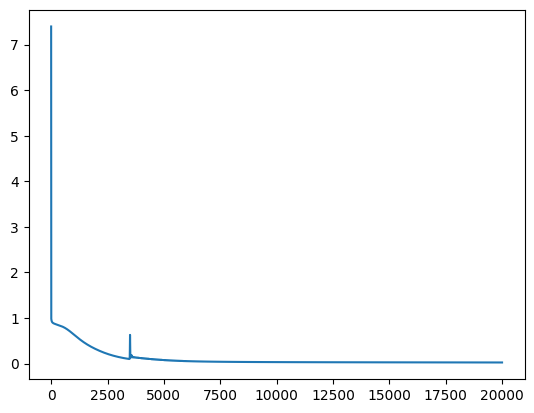

In [33]:
loss_l1=[]
for epoch in range(0, nbEpoch):    
    # --- X (m, n_in)
    # --- Y (m, n_out)
    # --- START CODE HERE
    hat_y = model(x_data)
    loss = torch.mean(torch.square(y_data - hat_y))
    # --- END CODE HERE
    
    if epoch % 1000 == 0:
        print('epoch {}, loss {}'.format(epoch, loss))
    loss_l1.append(loss.detach().numpy())
    loss.backward()
    
    with torch.no_grad():
        # --- START CODE HERE
        W1 -= alpha * W1.grad
        b1 -= alpha * b1.grad
        W2 -= alpha * W2.grad
        b2 -= alpha * b2.grad
        # --- END CODE HERE
        W1.grad.zero_()
        b1.grad.zero_()
        W2.grad.zero_()
        b2.grad.zero_()
plt.plot(loss_l1)
        
        

### Plotting the results

We will super-impose the biases of the first layer to better understand how the model has fit the sinusoidal curve. Please explain what it does.

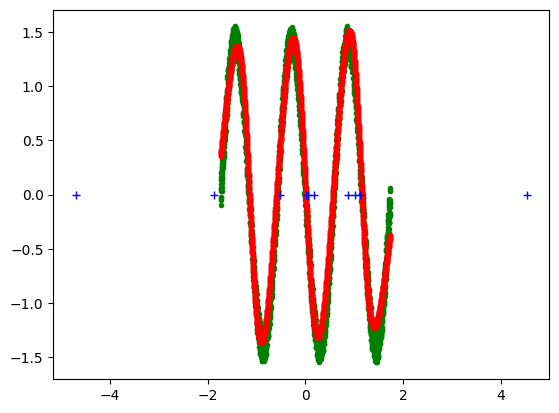

In [34]:
# ----------------
plt.plot(x_data.numpy(), y_data.numpy(), 'g.');
plt.plot(x_data.numpy(), hat_y.detach().numpy(), 'r.');
# super-impose the biases of the first layer
plt.plot(b1.detach().numpy(), np.zeros(b1.shape[0]), 'b+');

**answer 1 :** We remark that for both models, the best loss is obtained with tanh. 

In [35]:
# --- START CODE HERE
model2 = nn.Sequential(
          nn.Linear(n_in, n_h),
          nn.Tanh(),
          nn.Linear(n_h, n_out)
        )
# --- END CODE HERE

In [36]:
# --- START CODE HERE
criterion2 = torch.nn.MSELoss()
optimizer2 = optim.SGD(model2.parameters(), lr = alpha)
# --- END CODE HERE

epoch 0, loss 1.573714017868042
epoch 1000, loss 0.8589402437210083
epoch 2000, loss 0.7970173954963684
epoch 3000, loss 0.6593717336654663
epoch 4000, loss 0.6109229326248169
epoch 5000, loss 0.577035129070282
epoch 6000, loss 0.5327319502830505
epoch 7000, loss 0.352887362241745
epoch 8000, loss 0.1506771296262741
epoch 9000, loss 0.11370618641376495
epoch 10000, loss 0.0963965579867363
epoch 11000, loss 0.10196660459041595
epoch 12000, loss 0.09573103487491608
epoch 13000, loss 0.0894695445895195
epoch 14000, loss 0.08000907301902771
epoch 15000, loss 0.06686573475599289
epoch 16000, loss 0.052756257355213165
epoch 17000, loss 0.04242614284157753
epoch 18000, loss 0.032709863036870956
epoch 19000, loss 0.025054138153791428


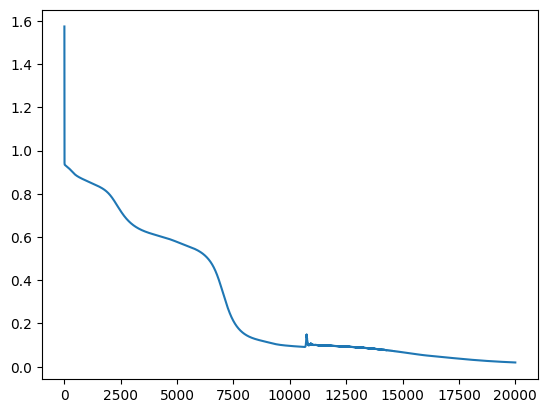

In [37]:
# Model 2
loss_l2 = []
for epoch in range(nbEpoch):
  
    # --- START CODE HERE
    pred_y2 = model2(x_data)
    loss2 = criterion2(pred_y2, y_data)
    loss_l2.append(loss2.detach().numpy())
    
    optimizer2.zero_grad()
    loss2.backward()
    optimizer2.step()
    if epoch % 1000 == 0:
        print('epoch {}, loss {}'.format(epoch, loss2.data))
        
# ----------------
plt.plot(loss_l2)

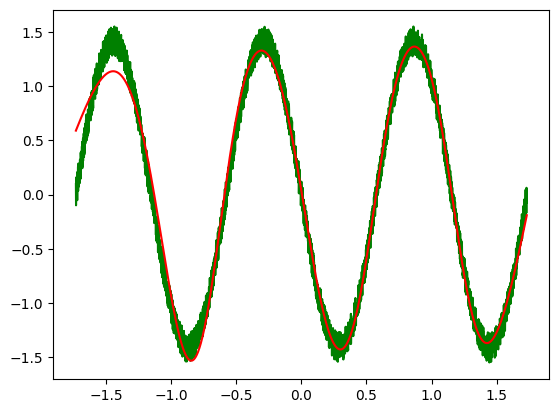

In [38]:
plt.plot(x_data.numpy(), y_data.numpy(), 'g')
plt.plot(x_data.numpy(), pred_y2.detach().numpy(), 'r')

## Model 3 (using a class definition)

Here, you will write the network using the recommended pytorch way; i.e. by defining a class.
This class inherit from the main class ```torch.nn.Module```.
You only need to write the ```__init__``` method and the ```forward``` method.

In object programming, the ```__init__``` method defines the attributes of your class. Since the attributes of your  network are the parameters to be trained (weights and biases), you should declare in the ```__init``` all the layers that involve parameters to be trained (mostly the ```Linear```layers which perform the matrix multiplication).

The ```forward``` method contains the code of the forward pass itself. It can of course call attributes defined in the ```__init___``` method. It is the method used when calling ```model(x)```.

As before, the model created will have all its parameters accessible as a dictionary and can be accessed using ```model.parameters()```. 

Classes are convenient way to write more complex network than what you can do with ```nn.sequential```. Note that you can actually include a ```nn.sequential``` in your class.

In [39]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # --- START CODE HERE
        self.hidden = nn.Linear(n_in, n_h)
        self.predict = nn.Linear(n_h, n_out)
        # --- END CODE HERE
        
    def forward(self, x):
        
        # --- START CODE HERE
        
        H = self.hidden(x)
        A = nn.Tanh()(H)
        hat_y = self.predict(A)

        # --- END CODE HERE
        
        return hat_y

# --- START CODE HERE
model3 = Net()
# --- END CODE HERE

## Criterion and Optimization for model 2 and model 3

The code of Model 1 is self-contained, i.e. it already contains all necessary instruction to perform forawrd, loss, backward and parameter updates.

When using ```nn.sequential``` (model 2) or a class definition of the network (model 3), we still need to define 
- what we will minimize (the loss to be minimized, i.e. Mean-Square-Error or Binary-Cross-Entropy). We can of course write the equation of it by hand but pytorch comes with a very large number of pre-build loss functions (within ```torch.nn```)
- how we will minimize the loss, i.e. what parameter update alogirhtms we will use (SGD, momentum). We can of course write the equation of it by hand but pytorch comes with a very large number of pre-build loss functions (within ```torch.nn```)

L2 regularization can be done directly in the optimizer under the name ```weight_decay```.

In [40]:
# --- START CODE HERE
criterion3 = torch.nn.MSELoss()
optimizer3 = optim.SGD(model3.parameters(), lr = alpha)
# --- END CODE HERE

## Training for model 2 and 3

Having defined the network, the citerion to be minimized and the optimizer, we then perform a loop over epochs (iterations); at each step we
- compute the forward pass by passing the data to the model: ```haty = model(x)```
- compute the the loss (the criterion)
- putting at zero the gradients of all the parameters of the network (this is important since, by default, pytorch accumulate the gradients over time)
- computing the backpropagation (using as before ```.backward()```)
- performing one step of optimization (using ```.step()```)

epoch 0, loss 1.2475146055221558
epoch 1000, loss 0.8635622262954712
epoch 2000, loss 0.8178027272224426
epoch 3000, loss 0.7229994535446167
epoch 4000, loss 0.6145099997520447
epoch 5000, loss 0.31058046221733093
epoch 6000, loss 0.06370859593153
epoch 7000, loss 0.047667380422353745
epoch 8000, loss 0.038725946098566055
epoch 9000, loss 0.03380950540304184
epoch 10000, loss 0.030055653303861618
epoch 11000, loss 0.026654494926333427
epoch 12000, loss 0.023476488888263702
epoch 13000, loss 0.020569300279021263
epoch 14000, loss 0.018040673807263374
epoch 15000, loss 0.015965772792696953
epoch 16000, loss 0.014341621659696102
epoch 17000, loss 0.013104011304676533
epoch 18000, loss 0.012164770625531673
epoch 19000, loss 0.011441844515502453


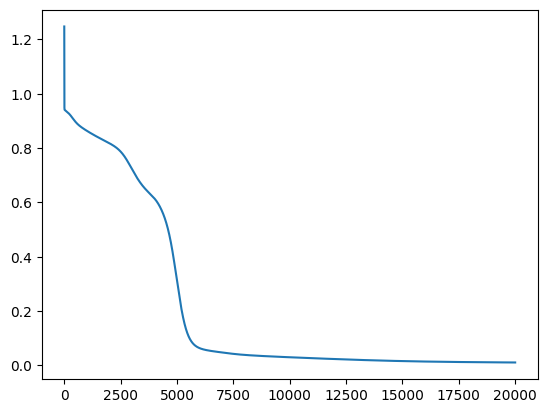

In [41]:
# Model 3
loss_l3 = []
for epoch in range(nbEpoch):
  
    # --- START CODE HERE
    pred_y3 = model3(x_data)
    loss3 = criterion3(pred_y3, y_data)
    loss_l3.append(loss3.detach().numpy())
    
    optimizer3.zero_grad()
    loss3.backward()
    optimizer3.step()
    if epoch % 1000 == 0:
        print('epoch {}, loss {}'.format(epoch, loss3.data))
        
# ----------------
plt.plot(loss_l3)

## Plotting results

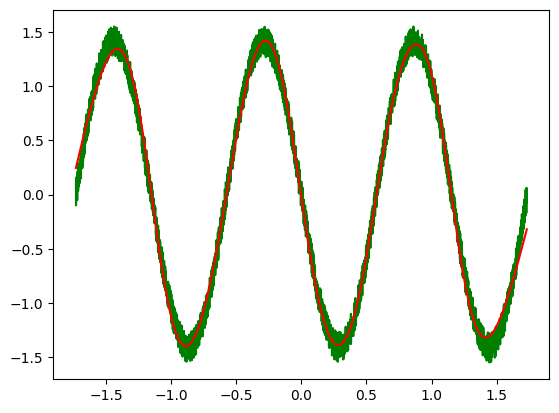

In [42]:
# ----------------
plt.plot(x_data.numpy(), y_data.numpy(), 'g')
plt.plot(x_data.numpy(), pred_y3.detach().numpy(), 'r')

Now let's do the L2 Regularization

In [43]:
# --- START CODE HERE
criterion3L2 = torch.nn.MSELoss()
optimizer3L2 = optim.SGD(model3.parameters(), lr = alpha, weight_decay = 0.0001)
# --- END CODE HERE

epoch 0, loss 0.010871358215808868
epoch 1000, loss 0.010492706671357155
epoch 2000, loss 0.010163220576941967
epoch 3000, loss 0.009875325486063957
epoch 4000, loss 0.009622402489185333
epoch 5000, loss 0.009399287402629852
epoch 6000, loss 0.00920177437365055
epoch 7000, loss 0.00902638304978609
epoch 8000, loss 0.008870099671185017
epoch 9000, loss 0.008730373345315456
epoch 10000, loss 0.0086051682010293
epoch 11000, loss 0.008492570370435715
epoch 12000, loss 0.008391034789383411
epoch 13000, loss 0.00829919520765543
epoch 14000, loss 0.00821592751890421
epoch 15000, loss 0.008140199817717075
epoch 16000, loss 0.008071158081293106
epoch 17000, loss 0.00800806749612093
epoch 18000, loss 0.0079502509906888
epoch 19000, loss 0.007897119037806988


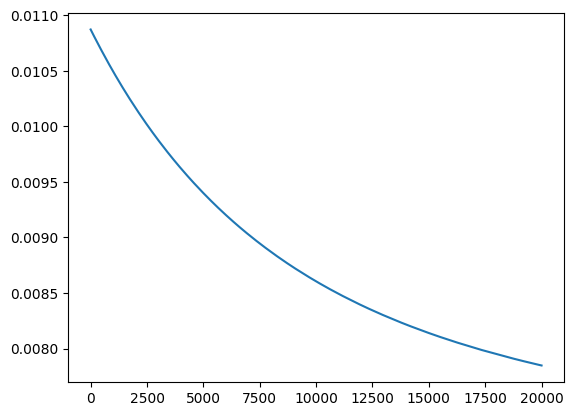

In [44]:
# Model 3 with L2 regularization
loss_l3L2 = []
for epoch in range(nbEpoch):
  
    # --- START CODE HERE
    pred_y3L2 = model3(x_data)
    loss3L2 = criterion3L2(pred_y3L2, y_data)
    loss_l3L2.append(loss3L2.detach().numpy())

    optimizer3L2.zero_grad()
    loss3L2.backward()
    optimizer3L2.step()
    
    if epoch % 1000 == 0:
        print('epoch {}, loss {}'.format(epoch, loss3L2.data))
        
# ----------------
plt.plot(loss_l3L2)

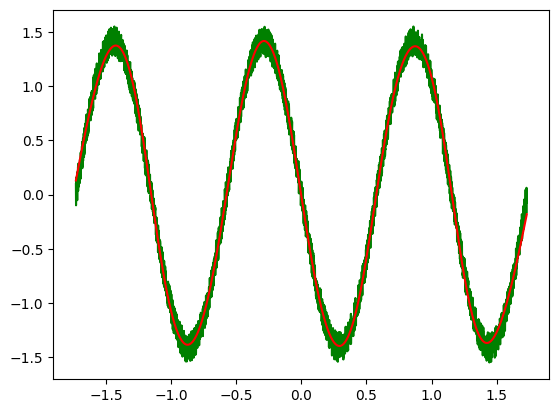

In [45]:
plt.plot(x_data.numpy(), y_data.numpy(), 'g')
plt.plot(x_data.numpy(), pred_y3L2.detach().numpy(), 'r')

## Display the weights and the biases

Now, we want to check the effect of L1 regularization. For this you will plot the values of the weights of each layers.

epoch 0, loss 0.012727473862469196
epoch 1000, loss 0.012649469077587128
epoch 2000, loss 0.012589920312166214
epoch 3000, loss 0.012539860792458057
epoch 4000, loss 0.012496108189225197
epoch 5000, loss 0.012457095086574554
epoch 6000, loss 0.012421861290931702
epoch 7000, loss 0.012389842420816422
epoch 8000, loss 0.0123605877161026
epoch 9000, loss 0.012333786115050316
epoch 10000, loss 0.012309134006500244
epoch 11000, loss 0.012286286801099777
epoch 12000, loss 0.012265068478882313
epoch 13000, loss 0.01224534586071968
epoch 14000, loss 0.01222692709416151
epoch 15000, loss 0.01220970693975687
epoch 16000, loss 0.012193487025797367
epoch 17000, loss 0.0121782086789608
epoch 18000, loss 0.012163832783699036
epoch 19000, loss 0.012150187976658344


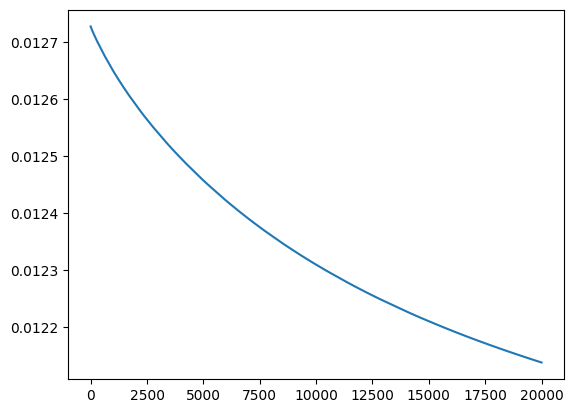

In [46]:
# Model 3
loss_l3L1 = []
lambda_l1 = 0.0001
for epoch in range(nbEpoch):
  
    # --- START CODE HERE
    pred_y3L1 = model3(x_data)
    loss3L1 = criterion3(pred_y3L1, y_data)
    l1_reg = torch.tensor(0.)
    for param in model3.parameters():
      if param.dim() > 1:  # check if parameter is not a bias
        l1_reg += torch.norm(param, 1)
    loss3L1 += lambda_l1 * l1_reg
    loss_l3L1.append(loss3L1.detach().numpy())

    optimizer3.zero_grad()
    loss3L1.backward()
    optimizer3.step()
    
    if epoch % 1000 == 0:
        print('epoch {}, loss {}'.format(epoch, loss3L1.data))
        
# ----------------
plt.plot(loss_l3L1)

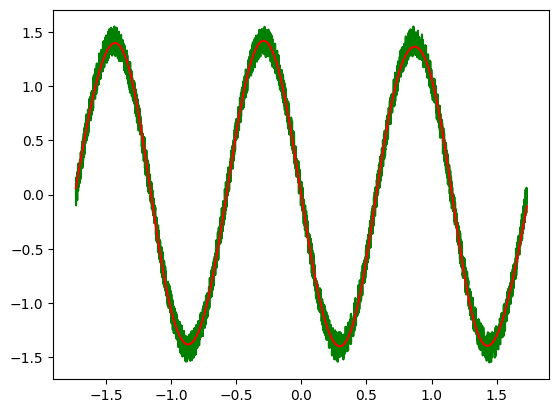

In [47]:
# ----------------
plt.plot(x_data.numpy(), y_data.numpy(), 'g')
plt.plot(x_data.numpy(), pred_y3L1.detach().numpy(), 'r')

[[ 3.4153628 ]
 [ 0.37825042]
 [-1.1438243 ]
 [ 3.5583224 ]
 [ 3.1472695 ]
 [ 4.3022027 ]
 [-0.32935697]
 [-3.436723  ]
 [ 1.98049   ]
 [ 1.5620956 ]]
[ 1.8726083   0.62247413  1.9557955  -4.218742    0.07263499 -2.3727279
  0.11056213 -4.0412984   3.463924   -2.6959405 ]
[[ 2.5013158  1.3701322 -2.433271  -3.7182748 -3.1132855  1.8032037
  -1.2009832  3.456      3.750814   2.9239414]]
[0.20201588]


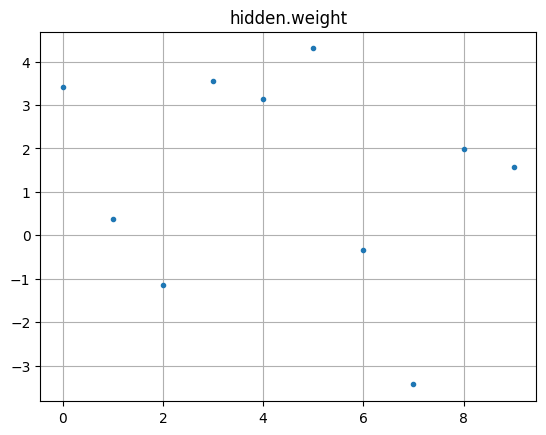

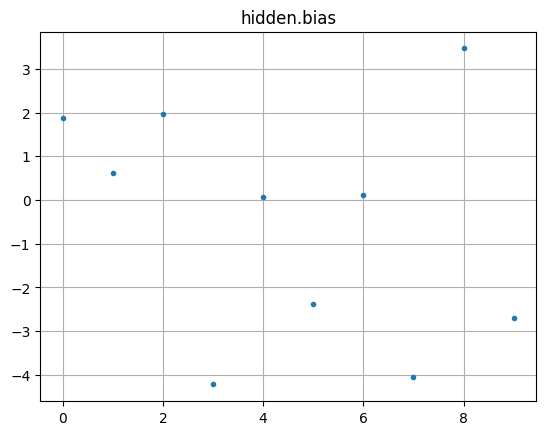

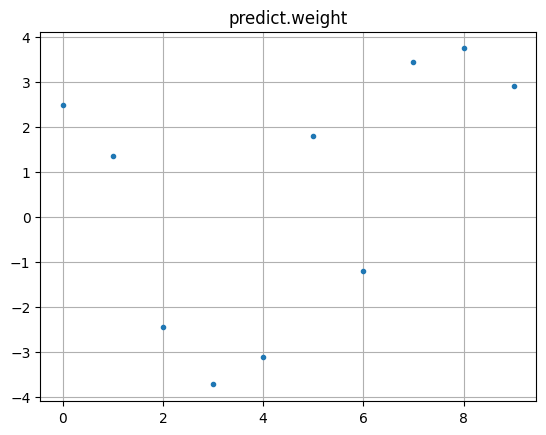

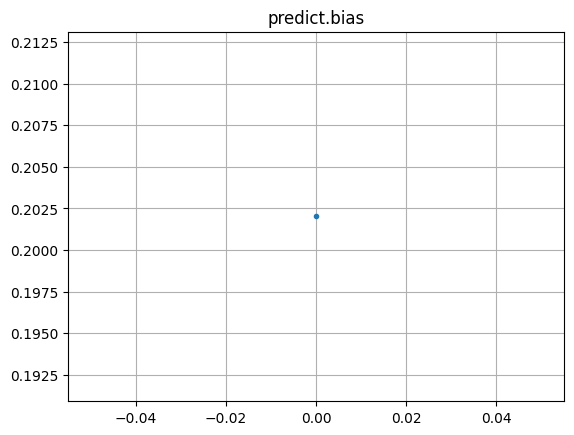

In [48]:
list_l = [{'name':name, 'data':layer.data} for name, layer in model3.named_parameters()]
for tmp in list_l:
    plt.figure()
    plt.plot(tmp['data'].flatten().numpy(), '.')
    plt.title(tmp['name'])
    plt.grid(True)
    print(tmp['data'].numpy())

**Question 2 :** 

**dataset A :** Here the efficiency of the L1 or L2 regularisation is less visible, maybe because the model seems to have more noise.

**dataset B :** Here the L1 and the L2 regularisation is less good because the model is quite hard, harder that model A. I guess my L1 regularization tries to represent the signal with a too simple model. My L2 is a bit better than my L1.